# Explortatory Data Analysis  

The following is an exploratory data analysis of energy usage data for Austin Street Brewery Company. The raw data has been procured directly from Central Maine Power. Austin Street's principle energy supplier. 

___

 ## Packages

In [48]:
import matplotlib.pyplot as plt
import pyarrow.parquet   as pq
import numpy as np
import seaborn as sns  
import pandas as pd

## Read in Data

In [49]:
df = pq.read_table('/Users/nelsonfarrell/Documents/Northeastern/5110/final_project/project-fall23-jparkington/data/cmp/curated/meter-usage').to_pandas()

## Display General Information

The dataframe is a compilation of CMP energy usage data for the 7 meters associated with Austin Street Brewery Company. The are 5 columns and 500,279 rows. There is no missing data.

**Column Name -- Datatype -- Description**  
* ```service_point_id``` - (int) - this is an identification number associated with the point of service
* ```meter_id``` - (str) - this is an identification number associated an individual meter
* ```interval_end_datetime``` - (str) - this is the ending time of interval for which the kwh is measured. These intervals are generally 15 minutes
* ```meter_channel``` - (int) - channel associated with an individual meter
* ```kwh``` - (kwh) - amount of energy used in a given interval measured in kilwatt hours
* ```account_number``` - (str) - account assiciated with a meter and bill

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500280 entries, 0 to 500279
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   service_point_id       500280 non-null  int64   
 1   meter_id               500280 non-null  object  
 2   interval_end_datetime  500280 non-null  object  
 3   meter_channel          500280 non-null  int64   
 4   kwh                    500280 non-null  float64 
 5   account_number         500280 non-null  category
dtypes: category(1), float64(1), int64(2), object(2)
memory usage: 19.6+ MB


In [51]:
df.head()

,service_point_id,meter_id,interval_end_datetime,meter_channel,kwh,account_number
0,2300822246,L108605388,10/1/2022 12:00:00 AM,10,0.594,30010320353
1,2300822246,L108605388,10/1/2022 12:15:00 AM,10,0.101,30010320353
2,2300822246,L108605388,10/1/2022 12:30:00 AM,10,0.104,30010320353
3,2300822246,L108605388,10/1/2022 12:45:00 AM,10,0.106,30010320353
4,2300822246,L108605388,10/1/2022 1:00:00 AM,10,0.099,30010320353


## Feature Engineering  

This section contains reformatting of columns and the generation of new columns.  
* ```interval_date_time``` (datetime): Convert to datetime datatype   
* ```year``` (int): Extracted and added as its own column
* ```month``` (int): Extracted and added as its own column
* ```month_name``` (str): Extracted and added as its own column
* ```kwh_normalized``` (float):  Normalization will done by ```meter_id```. In other words, the mean and standard deviation will be computed by groups $ \sim \Large \frac{kwh - \mu}{\sigma}$
* ```extreme_outlier``` (bool): this column will indicate if ```kwh_normalized``` is greater than 3 or less than -3

In [52]:
# general feature engineering
df['interval_end_datetime'] = pd.to_datetime(df['interval_end_datetime'], format = '%m/%d/%Y %I:%M:%S %p')
df['year'] = df['interval_end_datetime'].dt.year
df['month'] = df['interval_end_datetime'].dt.month
df['month_name'] = df['interval_end_datetime'].dt.strftime('%B')
df.sort_values('month', inplace = True)

# normalizing kwh by meter_id
grouped_df = df.groupby('meter_id').agg({'kwh': ['mean', 'std']})
grouped_df.reset_index(inplace = True)
grouped_df.columns = grouped_df.columns.droplevel(level = 1)
grouped_df.columns = ['meter_id', 'mean_kwh', 'std_kwh']
df = pd.merge(df, grouped_df, on = 'meter_id', how = 'left')
df['kwh_normalized'] = (df.kwh - df.mean_kwh)/df.std_kwh

# generate outlier bool column
df['extreme_outlier'] = df.kwh_normalized > 3


---

## Grouped Data Frame Generation  

In the section, a new dataframe will generated by grouping the dataframe by ```month```, ```year```, and ```meter_id``` and aggregating by **mean**, **max**, and **median**.

This dataframe will be used to examine the behavior of ```kwh``` with respect to ```meter_id``` in relation to various time intervals.

In [53]:
# generate and modify grouped dataframe
max_mean_dif_df = df.groupby(['month', 
                              'year', 
                              'meter_id']).agg({'kwh': ['max', 
                                                        'mean', 
                                                        'median'],
                                                'month_name': 'first'}).reset_index()

max_mean_dif_df['max_mean_diff'] = (((max_mean_dif_df.kwh['max'] - max_mean_dif_df.kwh['mean'])/max_mean_dif_df.kwh['mean']) * 100).round(2)
max_mean_dif_df.columns = max_mean_dif_df.columns.droplevel(level = 1)
max_mean_dif_df.columns = ['month', 'year', 'meter_id', 'max_usage', 'mean_usage', 'median_usage', 'month_name', 'max_mean_diff']

## Plot Function  

This function will be used to generate a comparative graphic of ```kwh``` (aggregated) with respect to ```meter_id```, ```year```, and ```month```.

In [54]:
def generate_usage_plot(df, x_col, y_col, hue_col, title) -> None:
    ''' 
        Function: generate_usage_plot
        Parameters: 1 pd.Frame, 3 pd.Series, 1 string
            df: the dataframe to be used to create the plot
            x_col: the column to be used for x axis
            y_col: the column to be used for y axis
            title: the title of the plot
        Returns: None

        This function will use seaborn and matplotlib to generate comparative displays of usage by meter over time.
    '''
    # extract the years to iterate with, put in descending order
    years = np.sort(df.year.unique())[::-1]

    plot = sns.set_style("whitegrid")
    fig, axes = plt.subplots(4, 1, figsize = (8, 10), sharex = True)
    j = 0
    fig.suptitle(f'{title}',
                weight = 'bold',
                fontsize = 16)
    fig.supxlabel('Month', 
                weight = 'bold')
    fig.supylabel('Usage in Kilowatt Hours',
                weight = 'bold')
    for i in years:
        sns.scatterplot(data = df.loc[df.year == i], 
                        x = x_col, 
                        y = y_col, 
                        ax = axes[j],
                        hue = hue_col,
                        palette = 'Paired')
        axes[j].set_title(years[j])
        axes[j].set_xlabel(None)
        axes[j].set_ylabel(None)
        if j != 3:
            axes[j].get_legend().remove()
        j += 1
    plt.legend(title = 'Meter IDs', 
            ncols = 1, 
            fancybox = True, 
            shadow = True,
            bbox_to_anchor = (1.25, 4.65))
    plt.xticks(rotation = 45);

    return None

---

## Distribution of KWH by Meter ID & Year

This graphic displays the distribution of ```kwh_normalized``` by ```meter_id```  and ```year```

This graphic shows that there are extreme outliers for all the meters. This indicates that power usage spikes significantly on all of the meters at various points. The maximum power usage over an interval of time impacts the monthly cost of power. Part of our analysis will be indentify the cause of these spikes and potential reduction strategies.

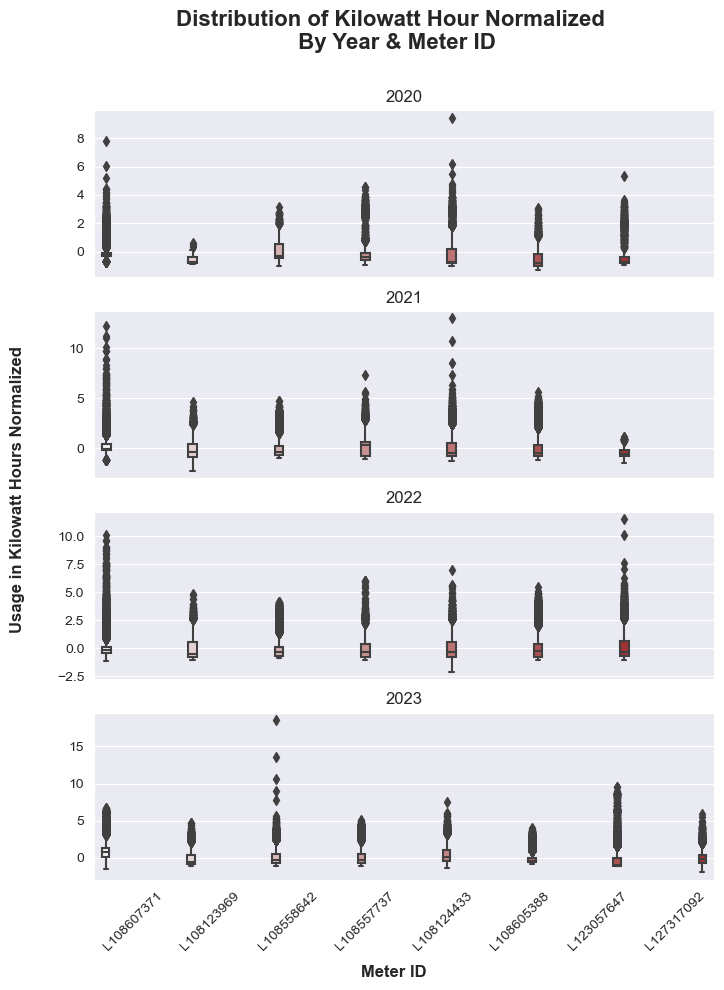

In [40]:
years = np.sort(df.year.unique())
sns.set_style('darkgrid')

fig, axes = plt.subplots(4, 1, figsize = (8, 10), sharex = True)
j = 0
fig.suptitle('Distribution of Kilowatt Hour Normalized \n By Year & Meter ID',
             weight = 'bold',
             fontsize = 16)
fig.supxlabel('Meter ID', 
              weight = 'bold')
fig.supylabel('Usage in Kilowatt Hours Normalized',
              weight = 'bold')
for i in years:
    sns.boxplot(data = df.loc[df.year == i], 
                 x = 'meter_id', 
                 y = 'kwh_normalized', 
                 ax = axes[j],
                 hue = 'meter_id',
                 color = 'firebrick')
    axes[j].set_title(years[j])
    axes[j].set_xlabel(None)
    axes[j].set_ylabel(None)
    axes[j].get_legend().remove()
    j += 1
plt.xticks(rotation = 45);

---

## Mean and Max Usage

The below graphics demonstrate the behavior usage on the individual meters by month and year.  
 
The first graphic displays the max usage, the second graphic displays the mean usage, and the third graphic displays the percent difference between mean and max usage.

These graphics highlight the significant disparity between mean usage and max usage. This disparity can have a significant impact on the cost of energy and will be delineated throughout our project. Additionally, we aim to map these spikes to specific business operations and devise strageties to mitigate their impact.

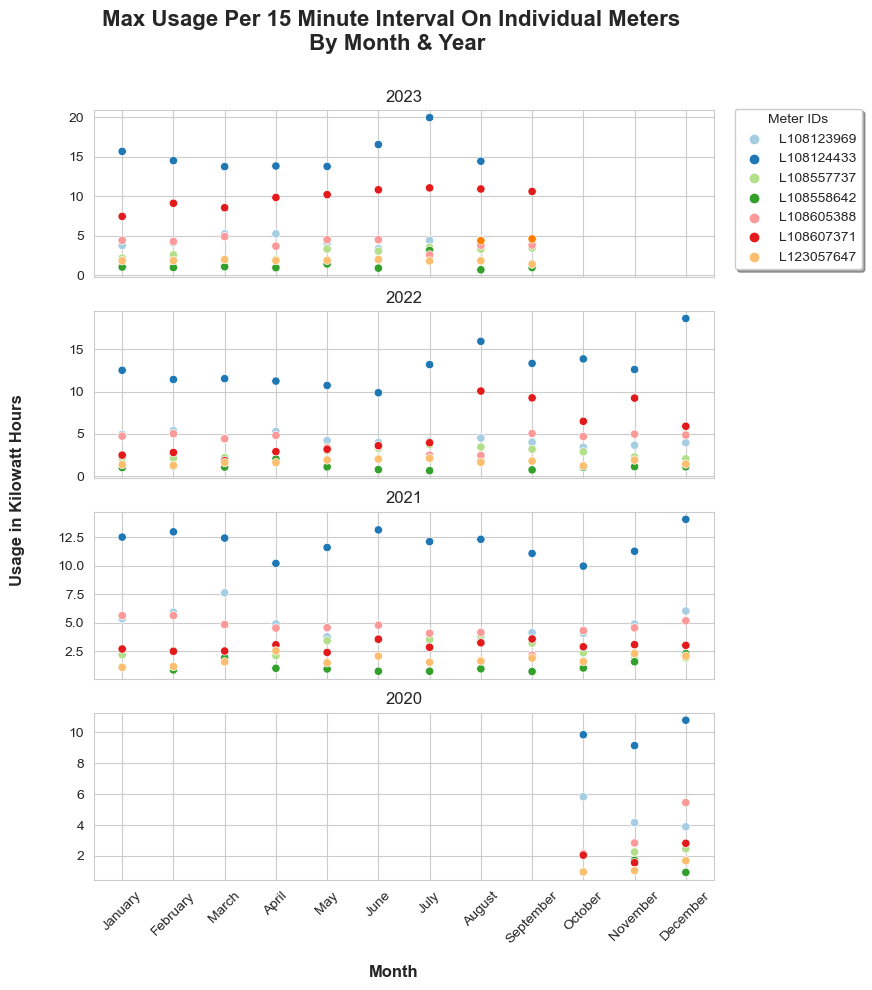

In [41]:
generate_usage_plot(max_mean_dif_df, 
                    'month_name', 
                    'max_usage', 
                    'meter_id', 
                    'Max Usage Per 15 Minute Interval On Individual Meters \n By Month & Year')

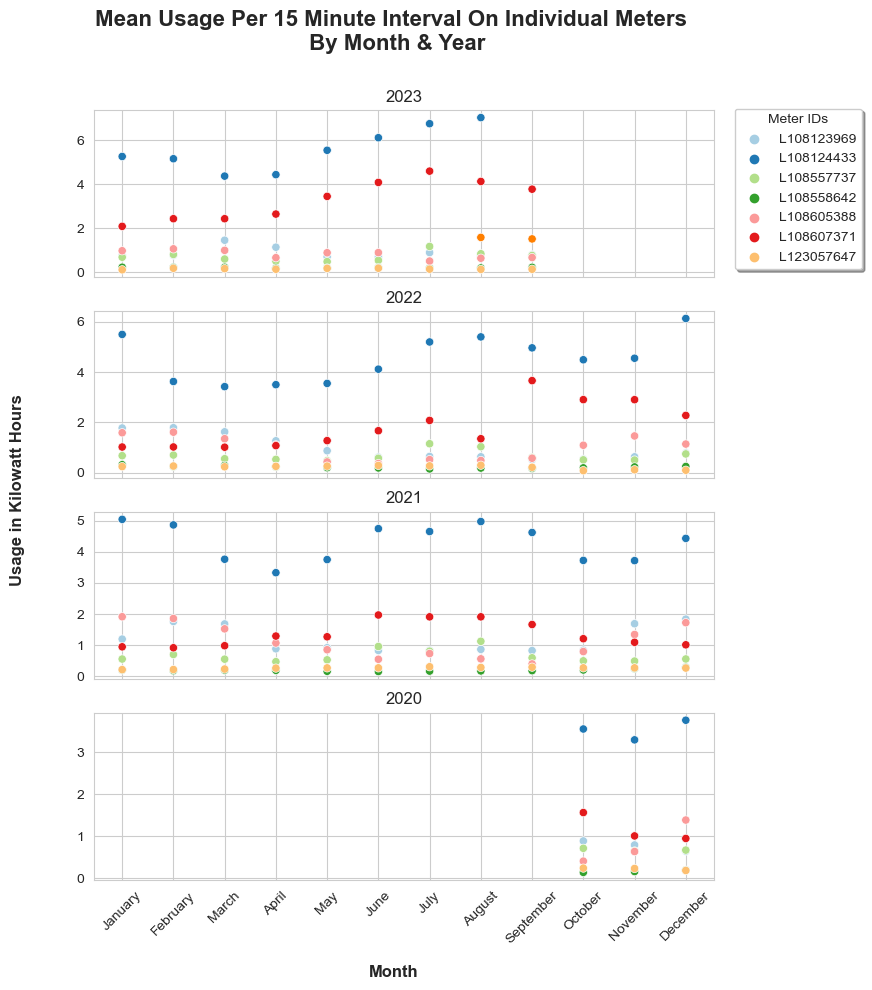

In [42]:
generate_usage_plot(max_mean_dif_df, 
                    'month_name', 
                    'mean_usage', 
                    'meter_id', 
                    'Mean Usage Per 15 Minute Interval On Individual Meters \n By Month & Year')

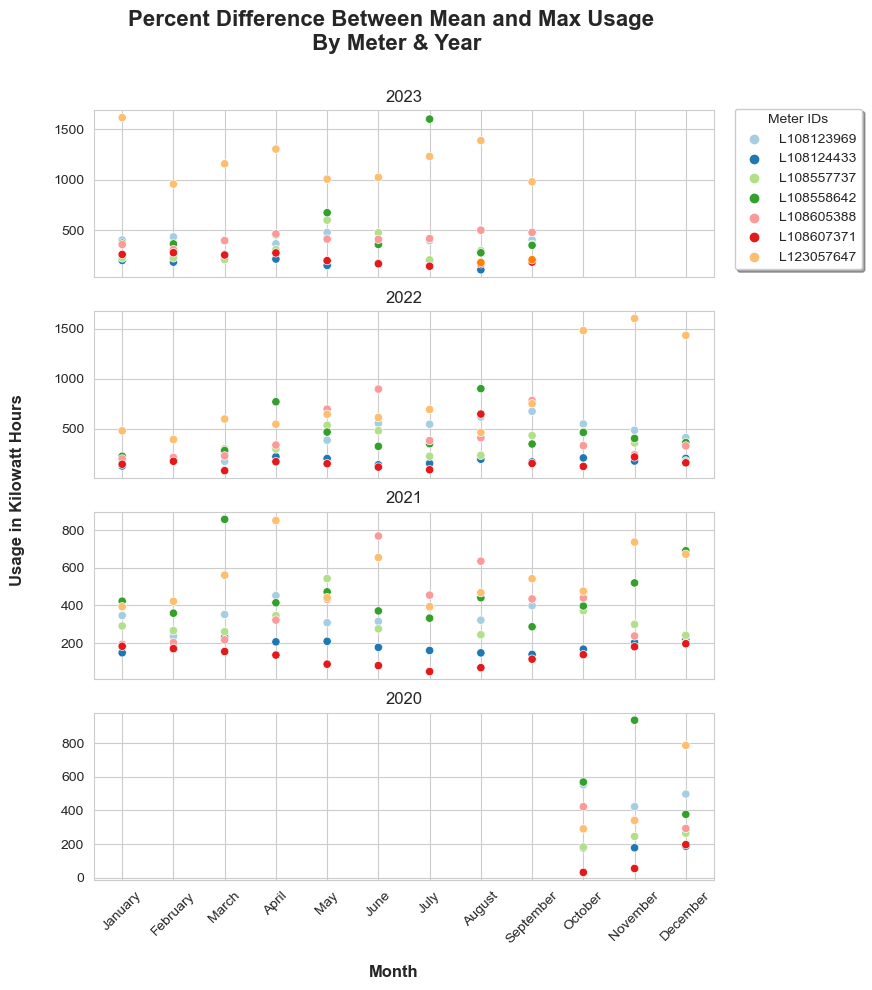

In [43]:
generate_usage_plot(max_mean_dif_df, 
                    'month_name', 
                    'max_mean_diff', 
                    'meter_id', 
                    'Percent Difference Between Mean and Max Usage \n By Meter & Year')

---

## Energy Spikes

If we define an energy spike as an interval whose power usage exceeds $3 * \sigma$ from $\mu$ of ```kwh``` by ```meter_id``` then there are 9329 energy usage spikes throughout the dataset. Paremeters and impacts will be more thoroughly defined and examinsed as we proceed.

The following graphics aim to highlight the frequency of energy spikes on the individual meters, and over time. 

While not performed in this EDA, a further area of interest is the duration of an engery spike once it occurs. This will be explored as the project progresses.

In [44]:
num_extreme_outliers = np.sum(df.extreme_outlier)
print('The total number of extreme outliers is:', num_extreme_outliers)

The total number of extreme outliers is: 9329


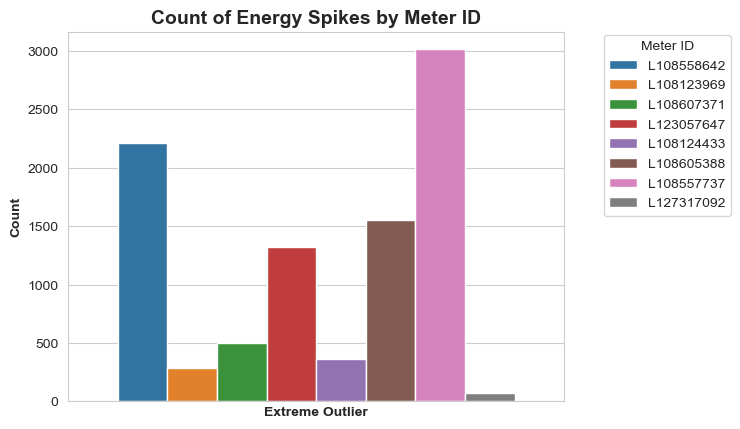

In [45]:
plot_df =  df.loc[df.extreme_outlier == True]

sns.countplot(data = plot_df, x = 'extreme_outlier', hue = 'meter_id')
plt.xlabel('Extreme Outlier',
            weight = 'bold')
plt.ylabel('Count',
            weight = 'bold')
plt.title('Count of Energy Spikes by Meter ID',
          weight = 'bold',
          fontsize = 14)
plt.xticks([])
plt.legend(title = 'Meter ID',
           bbox_to_anchor = (1.35, 1.01));

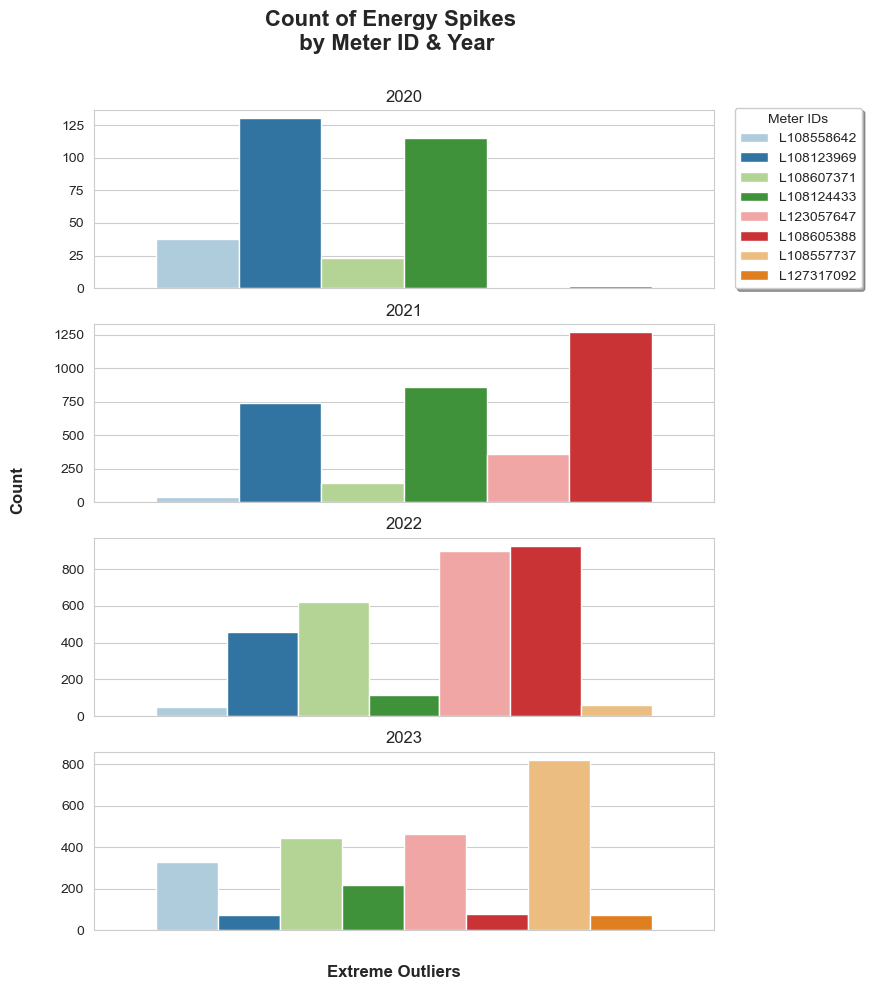

In [46]:
plot = sns.set_style("whitegrid")
fig, axes = plt.subplots(4, 1, figsize = (8, 10), sharex = True)
j = 0
fig.suptitle('Count of Energy Spikes \n by Meter ID & Year',
            weight = 'bold',
            fontsize = 16)
fig.supxlabel('Extreme Outliers', 
            weight = 'bold')
fig.supylabel('Count',
            weight = 'bold')
fig.subplots_adjust(bottom = .06)
for i in years:
    sns.countplot(data = plot_df.loc[df.year == i], 
                    x = 'extreme_outlier',  
                    ax = axes[j],
                    hue = 'meter_id',
                    palette = 'Paired')
    axes[j].set_title(years[j])
    axes[j].set_xlabel(None)
    axes[j].set_ylabel(None)
    if j != 3:
        axes[j].get_legend().remove()
    j += 1
plt.legend(title = 'Meter IDs', 
        ncols = 1, 
        fancybox = True, 
        shadow = True,
        bbox_to_anchor = (1.25, 4.65))
plt.xticks([])
plt.xticks(rotation = 45);

___
# Summary

This EDA has focused on energy usage, and more specifically, spikes in energy usage. Part of our project will be to attempt to ascertian what is causing these spikes and what actions can be taken to reduce their impact. While we are currently waiting for the data on which production machines map to which meter, when this information is received, it will enhance the substance of this line of inquiry. Additionally, we have learned that peak usage (defined as the maximum amount of energy that is required in a given period) impacts the amount of energy CMP will allocate for a meter, this in turn impacts price. We aim to not only identify what is driving energy usage, and usage spikes, but also to develope meaningful cost saving strategies going forward.  